In [1]:
from gibbs import *
import numpy as np
import pystan
from data_pertub import *
from mcmc_plot import *
from PPCA_pystan import *
import warnings
from PPCA_pystan import *
warnings.filterwarnings("ignore")

##  1. Generate Data

In [2]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
data_config = dict(config['data_config'])

In [3]:
n_sample = int(data_config['n_sample'])
alpha = float(data_config['alpha'])


d = int(data_config['d'])
q_star = int(data_config['q_star'])
a_vj = float(data_config['a_vj']) * np.ones(q_star)
epsilon = float(data_config['epsilon'])
beta_vj = epsilon * (a_vj - 1)
beta_sigma2 = float(data_config['beta_sigma2'])
a_sigma2 = float(data_config['a_sigma2'])

prior_param_true = dict({'beta_sigma2': beta_sigma2,
                         'a_sigma2': a_sigma2,
                         'a_vj': a_vj,
                         'beta_vj': beta_vj
                         })

true sigma2_star is 0.12392964742296957
true v_j list is [0.02490804]


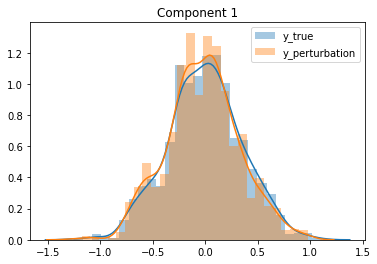

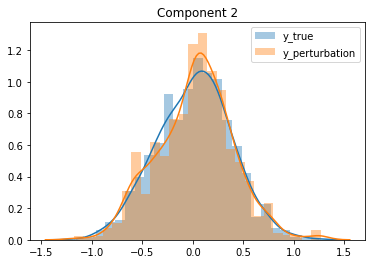

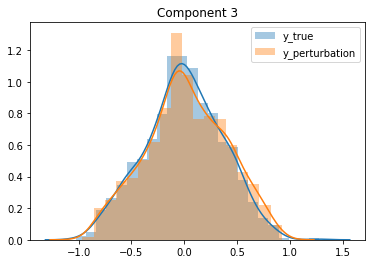

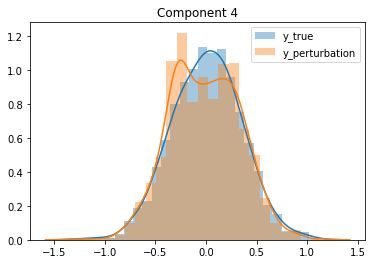

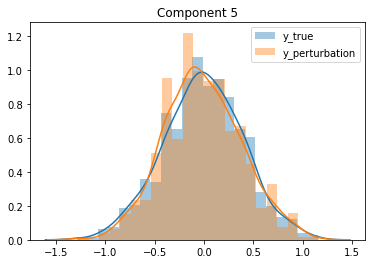

In [4]:
y_true, W_star, Z_star, sigma2_star, v_star_list = forward_sample(
    d, q_star, n_sample, prior_param_true, verbose=True)
y_perturbation = sample_perturbation2(y_true, n_sample, alpha)
#y_perturbation = forward_sample(d, q_star, n_sample, prior_param_true, verbose = True)

for j in range(d):
    sns.distplot(y_true[j, :], label='y_true')
    sns.distplot(y_perturbation[j, :], label='y_perturbation')
    plt.legend()
    plt.title('Component ' + str(j+1))
    plt.show()

In [5]:
X = y_true

## 2. MCMC Prior

In [6]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
mcmc_setup = dict(config['mcmc_setup'])

In [7]:
# inference parameter
d = int(data_config['d'])
q = int(mcmc_setup['q'])
xi = float(mcmc_setup['xi'])


# prior parameter
beta_sigma2 = float(mcmc_setup['beta_sigma2'])
a_sigma2 = float(mcmc_setup['a_sigma2'])
a_vj = float(mcmc_setup['a_vj']) * np.ones(q)
epsilon = float(mcmc_setup['epsilon'])
beta_vj = epsilon * (a_vj - 1)


# sampling parameter
prior_param_mcmc = dict({'beta_sigma2': beta_sigma2,
                         'a_sigma2': a_sigma2,
                         'a_vj': a_vj,
                         'beta_vj': beta_vj
                         })

In [8]:
n_chains = int(mcmc_setup['n_chains'])
iterations = int(mcmc_setup['iterations'])

## 3. MCMC Gibbs

In [9]:
mcmc_list = []
for sub_chains in range(n_chains):
    init_dict = dict({'Z0': np.random.normal(0, 1, [q, n_sample]),
                      "sigma20": sigma2_star,
                      # "w0": W_star,
                      'w0': np.random.normal(0, 1, [d, q]),
                      # 'v0': np.repeat(v_star_list, q).ravel(),
                       'v0': np.array(sorted(v_star_list))})
                      #'v0': sorted(1/np.random.gamma(a_vj, 1 / beta_vj))})

    inference = Model(X, init_dict, iterations, q, prior_param_mcmc, xi=1)
    mcmc_list.append(inference.gibbs_result())

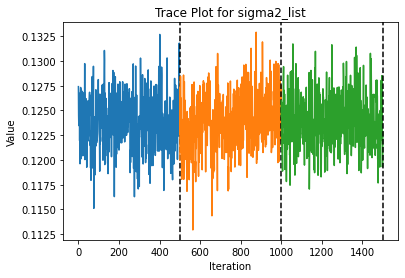

In [10]:
var_list = ['sigma2_list']
trace_plot(mcmc_list, var_list)

In [11]:
print(sigma2_star)

0.12392964742296957


In [12]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
#v_list = get_trace_list(mcmc_list, 'v_list')

In [13]:
#v_table = plot_v_density(v_list)

In [14]:
#np.mean(v_list, axis=1)

In [15]:
print(v_star_list)

[0.02490804]


## 4. MCMC Pystan Ordered $V_j$

In [16]:
init_list = []
for i_ in range(n_chains):
    temp_dict = {
        # 'v': np.repeat(v_star_list, q).ravel(),
        # 'v': sorted(v_star_list),
       # 'v': sorted(1/np.random.gamma(a_vj, 1 / beta_vj)),
        'sigma2': sigma2_star,
         "W": W_star.T

    }
    init_list.append(temp_dict)

In [17]:
sm = pystan.StanModel(model_code=ppca_code)  # code compile

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a5be0f07fed73f5660d0bd7cb818d9d3 NOW.


In [18]:
print(sm.model_code)


data { 
    int D; //number of dimensions
    int N; //number of data
    int Q; //number of principle components
//    matrix[N,D] x; // data
    vector[D] x[N]; //data
    real a_vj; // w_j prior 
    real epsilon;// w_j mean
    real xi; // power parameter
    real a_sigma2; // sigma2 prior 
    real beta_sigma2;// sigma2 mean
    vector[Q] v; // true v_j
}

transformed data {
    matrix[D,D] S;
    S = x[1] * x[1]';
    
    for (n in 2:N){
    S += x[n] * x[n]';
    }
    S = S/N;
    
}
parameters {
   // ordered[Q] v; // v_j
    real<lower=0> sigma2; //data sigma2
    matrix[Q,D] W; //projection matrix
}
model {
    matrix[D,D] C; //covaraince matrix
    for(j in 1:Q){
       // v[j] ~ inv_gamma(a_vj, epsilon * (a_vj -1));
        W[j] ~ multi_normal(rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
        }
        
    sigma2 ~ inv_gamma(a_sigma2, beta_sigma2);
    
    C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));
    

    target += - N/2 *(log_determinan

In [19]:
ppca_dat_standard = {'D': d,
                     'N': n_sample,
                     'Q': q,
                     'x': X.reshape([n_sample, d]),
                     'xi': 1,
                     'a_vj': a_vj[0],
                     'epsilon': epsilon,
                     'a_sigma2': a_sigma2,
                     'beta_sigma2': beta_sigma2,
                     'v': v_star_list
                     }

In [20]:
fit_standard = sm.sampling(data=ppca_dat_standard,
                           iter=iterations, chains=n_chains, init=init_list)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [21]:
def az_v_sigma2_plot(stan_fit, var_list = ['v','sigma2']):
        """
        Function to demonstrate pystan v convergence result through R_hat table, autocorrelation (3 chians), and trace plot
        """
#        print(az.summary(stan_fit, var_names=["v","sigma2",'W'], filter_vars="like"))
        print(az.summary(stan_fit, var_names = var_list))
#        az.plot_trace(stan_fit, var_names=['v','sigma2'], filter_vars="like")
        az.plot_trace(stan_fit, var_names = var_list)
        az.plot_autocorr(stan_fit, var_names = var_list)
#        az.plot_pair(stan_fit, var_names = var_list, divergences=True)
        


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
sigma2  0.132  0.003   0.127    0.138        0.0      0.0    1450.0  1450.0   

        ess_bulk  ess_tail  r_hat  
sigma2    1459.0     945.0    1.0  


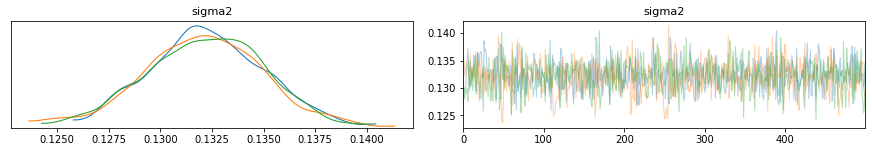

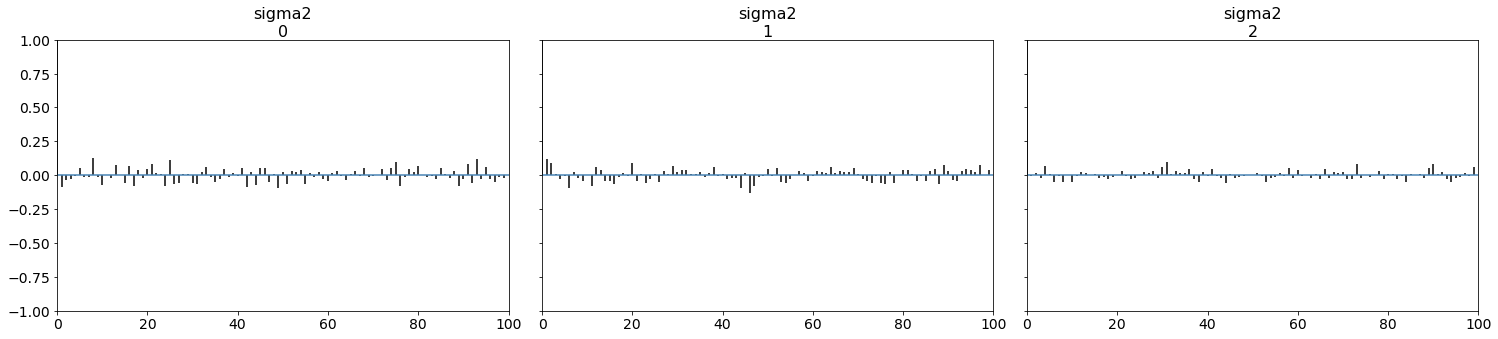

In [22]:
az_v_sigma2_plot(fit_standard, ['sigma2'])

In [23]:
print(v_star_list)

[0.02490804]


In [24]:
sigma2_star

0.12392964742296957

In [25]:
para_star = {'sigma2':sigma2_star,
             'W': W_star
            }

In [26]:
para_star = np.append(sigma2_star, W_star)

In [27]:
para_stan = np.append(fit_standard.get_last_position()[0]['sigma2'], fit_standard.get_last_position()[0]['W'])

In [28]:
para_init = np.append(fit_standard.get_inits()[0]['sigma2'], fit_standard.get_inits()[0]['W'])

In [33]:
print(para_star)
print(para_stan)
print(para_init)

[ 0.12392965 -0.01503023  0.08527507 -0.08190002 -0.04030664 -0.16942514]
[ 0.13456938 -0.02495467  0.03018184  0.07904072  0.0663012  -0.06038697]
[ 0.12392965 -0.01503023  0.08527507 -0.08190002 -0.04030664 -0.16942514]


In [29]:
fit_standard.log_prob(para_star)

-626.1158630102058

In [30]:
fit_standard.log_prob(para_stan)

-637.906209511542

In [31]:
fit_standard.log_prob(para_init)

-626.1158630102058

In [32]:
para_star

array([ 0.12392965, -0.01503023,  0.08527507, -0.08190002, -0.04030664,
       -0.16942514])